# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=',')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=',')

In [ ]:
import pickle

# Because reading from large csv files is rather slow, we pickle the azidas and customer dataframe.
azdias.to_pickle('azdias.pkl')
customers.to_pickle('customers.pkl')

In [3]:
azdias = pd.read_pickle('azdias.pkl')
customers = pd.read_pickle('customers.pkl')

## General data processing input files

In [4]:
# Show the shape of both the azdias and customers dataframe
print("shape azdias: %s, %s" % azdias.shape)
print("shape customers: %s, %s" % customers.shape)

shape azdias: 891221, 366
shape customers: 191652, 369


In [5]:
# Verify that the customer dataframe indeed contains the above mentioned three extra columns
print(set(customers.columns) - set(azdias.columns))

{'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'}


In [6]:
# Get feature information from the provided Excel files and custruct a dataframe.
feature_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx').drop(['Unnamed: 0'], axis=1)
# Set the header values to the values of the first row in the dataframe.
feature_info = feature_info.rename(columns=feature_info.iloc[0]).drop(feature_info.index[0])
# Forward fill the attribute column so we have the name of an attribute on all rows.
feature_info = feature_info.ffill()
# Determine the number of attributes we have in the feature info dataframe so we know which
# features we can map to a description.
print("Number of features in the feature info dataframe: %d" % feature_info['Attribute'].unique().size)

Number of features in the feature info dataframe: 314


In [7]:
# Get the provided information levels for the available features.
information_levels = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx').drop(['Unnamed: 0'], axis=1)
# Set the header values to the values of the first row in the dataframe.
information_levels = information_levels.rename(columns=information_levels.iloc[0])[['Information level', 'Attribute']]
# Remove the first row of the original dataframe since it contains the header names.
information_levels = information_levels.drop(information_levels.index[0])
# First row isn't filled correctly. Set information level of this row to 'person'.
information_levels.loc[information_levels['Attribute']=='AGER_TYP', 'Information level'] = 'Person'
# Forward fill the information level column so all attributes have the correct information level.
information_levels = information_levels.ffill()
# Determine the number of attributes we have in the information level dataframe
print("Number of features in the information level dataframe %d" % information_levels['Attribute'].size)

Number of features in the information level dataframe 318


In [8]:
# Add the information levels to the feature info dataframe
feature_info = feature_info.set_index('Attribute').join(information_levels.set_index('Attribute'))

In [9]:
# Determine the encoded missing values in the feature info dataframe.
unknown_values = feature_info.loc[feature_info['Meaning'].isin([
    'unknown','no classification possible','classification not possible','unknown / no main age detectable']
)]
# Because we want to split all the available missing values into a list we convert the value field to type string.
unknown_values = unknown_values.astype({"Value": "str"})

# Remove whitespaces in the value column to handle multiple values by line.
unknown_values['Value'] = unknown_values['Value'].str.replace(" ","")

# Convert the missing value indicators to a list and put them into a single line per attribute.
unknown_values = unknown_values.groupby('Attribute')['Value'] \
    .apply(lambda x: x.str.cat(sep=",")) \
    .apply(lambda x: x.split(",")) \
    .to_frame() \
    .rename(columns={'Value':'Missing'})

In [10]:
# Bring back the dataframe to the attribute level by selecting features and dropping duplicates.
# This way we can join the unknown_values dataframe and add the 'missing value' column.
feature_info = feature_info[['Description','Information level']].drop_duplicates()

In [11]:
# Add the missing column to the feature info dataframe and create the final feature summary dataframe.
feature_summary = feature_info.join(unknown_values, how='left')
print(feature_summary.shape)

(318, 3)


In [12]:
feature_summary.head()

,Description,Information level,Missing
Attribute,,,
AGER_TYP,best-ager typology,Person,"[-1, 0]"
ALTERSKATEGORIE_GROB,age classification through prename analysis,Person,"[-1, 0]"
ALTER_HH,main age within the household,Household,[0]
ANREDE_KZ,gender,Person,"[-1, 0]"
ANZ_HAUSHALTE_AKTIV,number of households in the building,Building,NaN


In [13]:
# Have a quick look a the number attributes who have encoded missing values.
feature_summary['Missing'].notnull().value_counts()

True     234
False     84
Name: Missing, dtype: int64

In [14]:
# Find the attributes who are both in azdias and feature_summary
print(len(set(azdias.columns).intersection(feature_summary.index)))

271


In [15]:
# Find the attributes who are in azdias but not in feature_summart
print(len(set(azdias.columns).difference(feature_summary.index)))

95


In [16]:
# Find the attributes who are in feature_summary but on in azdias
print(len(set(feature_summary.index).difference(azdias.columns)))

42


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [17]:
# We hebben natuurlijk missende data en data die encoded missing is. Hier iets mee doen

def find_missing_values(df):
    # Count the nummer of naturally missing values
    is_null = azdias.isnull().sum()
    # Count the number of not missing values
    not_null = azdias.notnull().sum()
    # Combine the missing and not missing counts in to one dataframe.
    combined = pd.concat([is_null, not_null], axis=1).rename(columns={0:'Missing', 1:'Not missing'})
    # Add missing percentage
    combined['Missing percentage'] = combined['Missing'] / (combined['Not missing'] + combined['Missing'])
    # Round missing percentages and sort in descending order
    combined = combined.round({'Missing percentage': 4}).sort_values(by='Missing percentage', ascending=False)
    # Return the combined dataframe where missing percentage > 0
    return combined.loc[combined['Missing percentage'] > 0]

In [18]:
missing_values = find_missing_values(azdias)
# Print the shape so we know how many columns have naturally missing values.
print(missing_values.shape)

(273, 3)


From above we can see that 273 columns in the azdias dataframe have naturally missing data.

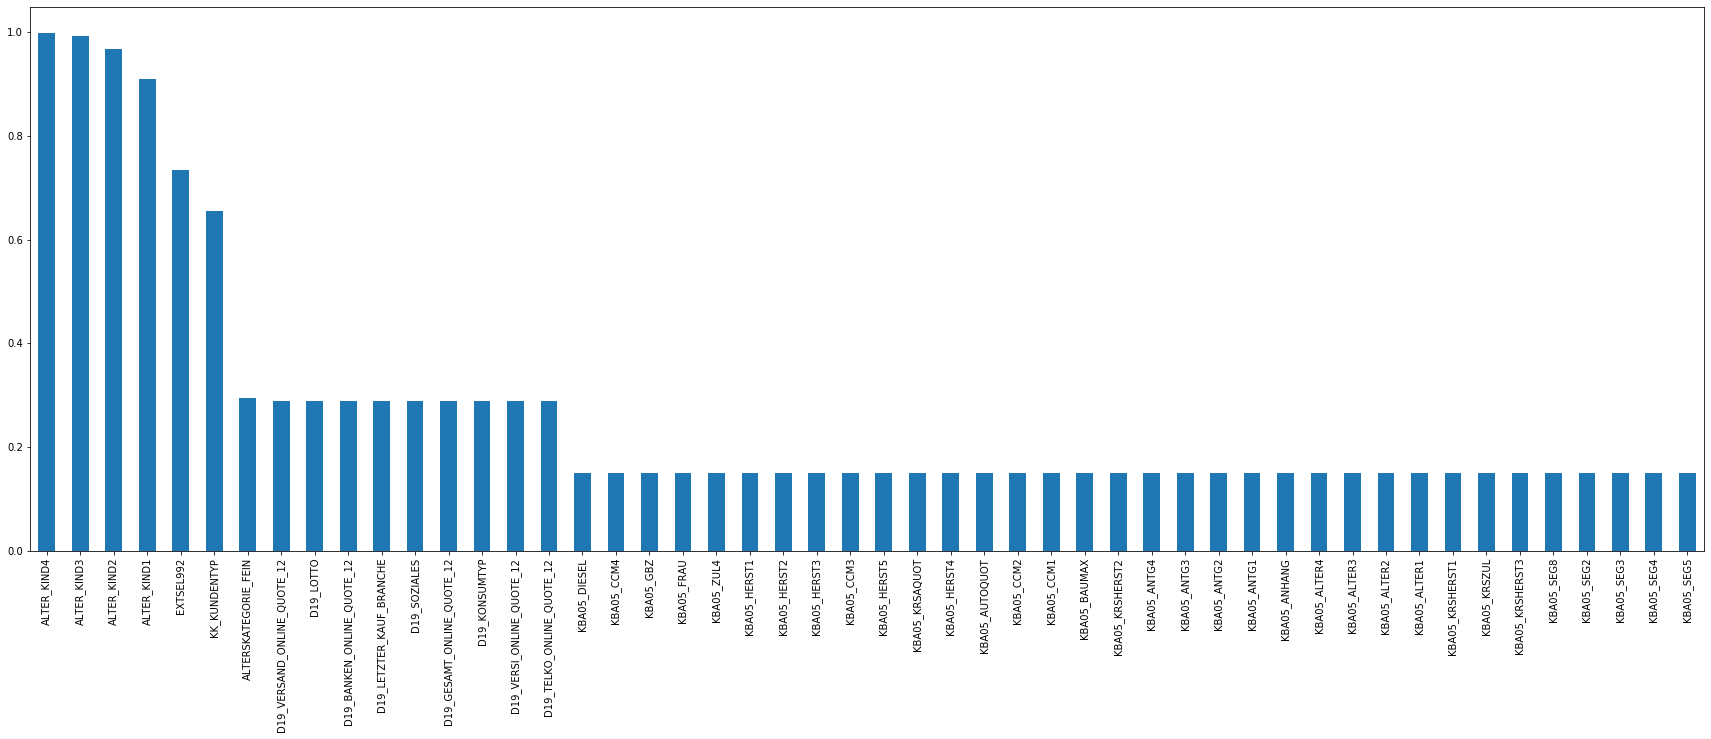

In [19]:
missing_values['Missing percentage'][:50].plot(kind='bar', figsize=(30, 10))

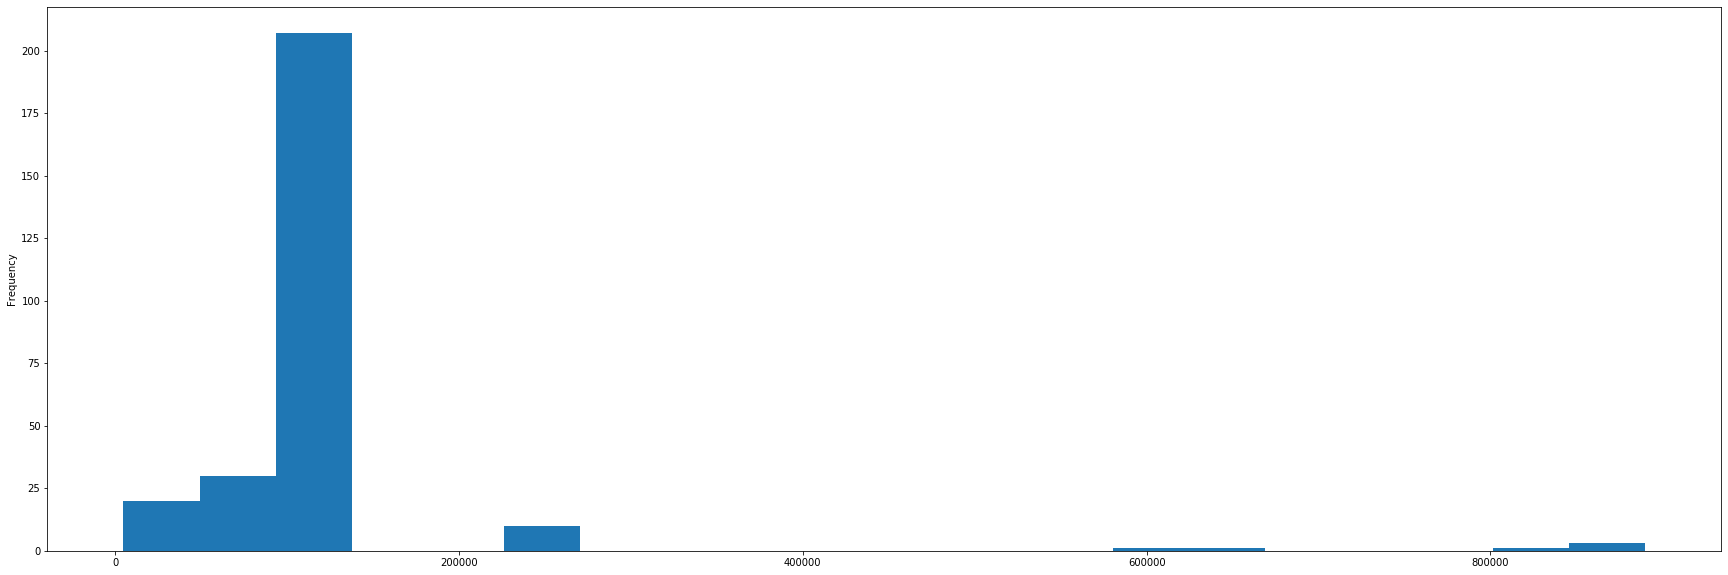

In [20]:
missing_values['Missing'].plot.hist(bins=20, figsize=(30, 10))

In [ ]:
feature_nans = feature_summary.loc[feature_summary['Missing'].notnull()]

In [ ]:
%%timeit

for column in azdias.columns:
    if column in feature_nans.index:
        azdias[column] = azdias[column].astype(str)
        azdias[column] = azdias[column].replace(feature_nans['Missing'][column], np.nan)

In [ ]:
feature_summary.loc[feature_summary['Missing'].notnull()]

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')